# Q0 <-> Q5 (coupler) <-> Q1 <-> Q2, Q1 <-> Q3 

In [70]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
import numpy.linalg as alg
import scqubits as scq
import sys
sys.path.insert(0, '..')
from QSwitch import QSwitchTunableTransmonCoupler
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import scipy.constants as cst
hbar = cst.hbar
h = cst.h
qe = cst.e
flux_quant = h/2/qe
red_flux_quant = hbar/2/qe 

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0
print(qe)

1.602176634e-19


In [72]:
def EC_GHz_from_C_fF(C_fF):
    return 1e-9 * qe**2 / (2*h*C_fF*1e-15)
def C_fF_from_EC_GHz(EC_GHz):
    return qe**2 / (1e9 * EC_GHz * 2*h*1e-15)

def LJ_H_from_EJ_GHz(EJ_GHz):
    return flux_quant**2 / (h*4*np.pi**2*EJ_GHz*1e9)

### Set qubit params

In [340]:
# Q3D VALUES
# All in SI units
# Q0: switch, Q1: in, Q2: out1, Q3: out2, Q4: coupler
# GOOD
Cjs =   np.array([74, 103, 87, 87, 37]) # fF
C04 =   12 # between Q0 and coupler pad closer to Q0
C041 =  0.56 # between Q0 and coupler pad farther from Q1
C41 =   10 # between Q1 and coupler pad closer to Q1
C410 =  0.53 # between Q1 and coupler pad farther from Q1
C01 =   0.062 # direct (parasitic) capacitance between Q0/Q1
Cg =    127 # between each coupler pad and ground

# Cjs =   np.array([85, 103, 87, 87, 37]) # fF
# C04 =   12 # between Q0 and coupler pad closer to Q0
# C041 =  0.56 # between Q0 and coupler pad farther from Q1
# C41 =   10 # between Q1 and coupler pad closer to Q1
# C410 =  0.53 # between Q1 and coupler pad farther from Q1
# C01 =   0.062 # direct (parasitic) capacitance between Q0/Q1
# Cg =    127 # between each coupler pad and ground

# C121 =  0 # between Q1 and Q1/Q2 capacitance bridge
# C122 =  0 # between Q2 and Q1/Q2 capacitance bridge
# C12g =  62 # between Q1/Q2 capacitance bridge and ground
# C12 =   0 # direct (parasitic) capacitance between Q1/Q2
# C131 =  0 # between Q1 and Q1/Q3 capacitance bridge
# C133 =  0 # between Q3 and Q1/Q3 capacitance bridge
# C13g =  63 # between Q1/Q3 capacitance bridge and ground
# C13 =   0 # direct (parasitic) capacitance between Q1/Q3

C121 =  9.54 # between Q1 and Q1/Q2 capacitance bridge
C122 =  9.21 # between Q2 and Q1/Q2 capacitance bridge
C12g =  62 # between Q1/Q2 capacitance bridge and ground
C12 =   0.197 # direct (parasitic) capacitance between Q1/Q2
C131 =  9.46 # between Q1 and Q1/Q3 capacitance bridge
C133 =  9.19 # between Q3 and Q1/Q3 capacitance bridge
C13g =  63 # between Q1/Q3 capacitance bridge and ground
C13 =   0.164 # direct (parasitic) capacitance between Q1/Q3

EJs_targets = np.array([18, 24, 26, 28, 17]) # GHz -> this is the total Ej of the squid, = EJ1+EJ2 
dEJ = 0.3 # (EJ1 - EJ2)/(EJ1 + EJ2)

# EJs_targets = np.array([16, 21, 26, 28, 21.5]) # GHz -> this is the total Ej of the squid, = EJ1+EJ2 
# dEJ = 0.1 # (EJ1 - EJ2)/(EJ1 + EJ2)

In [341]:
# Variable transformation to combine nodes 1 and 2 to get differential mode describing the tunable coupler
S = np.identity(9)
norm = 1
S[1, 1] = 1 * norm
S[1, 2] = 1 * norm
S[2, 1] = 1 * norm
S[2, 2] = -1 * norm
# print(S)
# print(alg.inv(S))

In [342]:
EJ1 = EJs_targets[-1] * (dEJ + 1)/2
EJ2 = EJs_targets[-1] * (1 - dEJ)/2

Ljs = LJ_H_from_EJ_GHz(EJs_targets)
Lj41 = LJ_H_from_EJ_GHz(EJ1)
Lj42 = LJ_H_from_EJ_GHz(EJ2)
print(f'Ljs Q0-Q4 (nH):', *(1e9*Ljs[:-1]))
print(f'Ljs SQUID (nH):', 1e9*Lj41, 1e9*Lj42)

c_matrix = np.zeros((9, 9))
c_matrix[0, 1] = -C04
c_matrix[0, 2] = -C041
c_matrix[0, 3] = -C01
c_matrix[0, 8] = -Cjs[0]
c_matrix[1, 2] = -Cjs[4]
c_matrix[1, 3] = -C410
c_matrix[1, 8] = -Cg
c_matrix[2, 3] = -C41
c_matrix[2, 8] = -Cg
c_matrix[3, 4] = -C131
c_matrix[3, 5] = -C121
c_matrix[3, 6] = -C12
c_matrix[3, 7] = -C13
c_matrix[3, 8] = -Cjs[1]
c_matrix[4, 7] = -C133
c_matrix[4, 8] = -C13g
c_matrix[5, 6] = -C122
c_matrix[5, 8] = -C12g
c_matrix[6, 8] = -Cjs[2]
c_matrix[7, 8] = -Cjs[3]
c_matrix += c_matrix.transpose()
for i in range(len(c_matrix)):
    c_matrix[i, i] = -sum(c_matrix[i, :])
c_matrix = alg.inv(S.transpose()) @ c_matrix @ alg.inv(S) # basis transformation to use differential mode
print('Check symmetric capacitances:', np.allclose(c_matrix*1e15, c_matrix.T*1e15))
c_matrix = 1e-15*c_matrix[:-1, :-1]

q01c_nodes = [0, 3, 2]
print('Coupling cap for Q0, Q1, Qc:\n', c_matrix[q01c_nodes][:, q01c_nodes])


# Use the post variable transformed nodes for this to get EJ right for the squid loop, so don't apply the basis transformation!
inv_l_matrix = np.zeros((9, 9))
inv_l_matrix[0, 8] = -1/Ljs[0]
# inv_l_matrix[1, 2] = -1/Lj41 - 1/Lj42
inv_l_matrix[2, 8] = -1/Lj41 - 1/Lj42
inv_l_matrix[3, 8] = -1/Ljs[1]
inv_l_matrix[6, 8] = -1/Ljs[2]
inv_l_matrix[7, 8] = -1/Ljs[3]
inv_l_matrix += inv_l_matrix.transpose()
for i in range(len(inv_l_matrix)):
    inv_l_matrix[i, i] = -sum(inv_l_matrix[i, :])
# print(inv_l_matrix)
# inv_l_matrix = alg.inv(S.transpose()) @ inv_l_matrix @ alg.inv(S) # basis transformation to use differential mode
inv_l_matrix = inv_l_matrix[:-1, :-1]

q_nodes = [0, 3, 6, 7, 2] # nodes in circuit diagram referring to Q0-4 and differential coupler (Q5) that was originally (node 1 - node 2)/sqrt(2)

print('Check symmetric capacitances:', np.allclose(c_matrix*1e15, c_matrix.T*1e15))
print('Check symmetric inductances:', np.allclose(inv_l_matrix, inv_l_matrix.T, rtol=1e5))
print('Shapes', c_matrix.shape, inv_l_matrix.shape)

Ljs Q0-Q4 (nH): 9.08119515593229 6.8108963669492155 6.2869812617992755 5.837911171670756
Ljs SQUID (nH): 14.792897086586533 27.472523160803565
Check symmetric capacitances: True
Coupling cap for Q0, Q1, Qc:
 [[ 8.662200e-14 -6.200000e-17 -5.720000e-15]
 [-6.200000e-17  1.329530e-13  4.735000e-15]
 [-5.720000e-15  4.735000e-15  1.062725e-13]]
Check symmetric capacitances: True
Check symmetric inductances: True
Shapes (8, 8) (8, 8)


# BEGIN ANALYSIS

In [343]:
inv_c_matrix = alg.inv(c_matrix)

ECs = qe**2/2/h * inv_c_matrix
EJs = flux_quant**2/h/4/np.pi**2 * inv_l_matrix
Zs = np.sqrt(8*np.diag(ECs)/np.diag(EJs))
gs = np.array([[4*ECs[i,j]/np.sqrt(Zs[i]*Zs[j]) for i in range(len(c_matrix))] for j in range(len(c_matrix))])
print('Check symmetric:', np.allclose(gs, gs.T))

print('Index (node) for Qi:', q_nodes)
print('Qubit print order: Q0, Q1, Q2, Q3, Q4 (TC)')
ECs = 1e-9*np.diag(ECs)[q_nodes]
EJs = 1e-9*np.diag(EJs)[q_nodes]
print('qubit ECs (GHz)\n', ECs)
print('qubit EJs (GHz)\n', EJs)
# print('all q-q gs (MHz)\n', 1e-6*gs)
# print('q-q gs (MHz)\n', 1e-6*gs[q_nodes][:, q_nodes])
gs = 1e-9 * np.array([gs[0,3], gs[3,6], gs[3,7], gs[0,6], gs[0,7], gs[6,7], gs[0,2], gs[3,2], gs[6,2], gs[7,2]]) # gs=[01, 12, 13, 02, 03, 23, 0c, 1c, 2c, 3c]

print('impedances (unitless)\n', *Zs[q_nodes])


"""
For each col, find row with max value, which is the node that it has the most population.
-> use node_pos to reference in EC, EJ
"""
evals_c, u1 = alg.eigh(inv_c_matrix)
u1 = np.array([u1[i]/np.sqrt(evals_c[i]) for i in range(len(evals_c))])
evals, evecs = alg.eigh(u1.transpose() @ inv_l_matrix @ u1)

node_pos = np.array([np.argmax(np.abs(evecs[:, i])) for i in range(len(c_matrix))])
node_counts = np.zeros_like(node_pos)
for m in range(len(c_matrix)):
    node_counts[m] += 1
if any(node_counts != 1): assert False, "Bad mapping of evecs to modes"
print()
print('Qubit modes are mapped (n_evec: n_node):', node_pos)
print('Modes (cols are evecs)\n', np.around(evecs, 3))


# AFTER HERE EVERYTHING IS INDEXED SO QUBIT NUMBER = INDEX AND EVERYTHING IS IN GHz


Check symmetric: False
Index (node) for Qi: [0, 3, 6, 7, 2]
Qubit print order: Q0, Q1, Q2, Q3, Q4 (TC)
qubit ECs (GHz)
 [0.22589463 0.14890865 0.20316181 0.20323817 0.18321769]
qubit EJs (GHz)
 [18. 24. 26. 28. 17.]
impedances (unitless)
 0.3168558214048423 0.22279186613046167 0.25002264876571656 0.24097313028932998 0.293632571997772

Qubit modes are mapped (n_evec: n_node): [5 7 6 1 2 3 0 4]
Modes (cols are evecs)
 [[-0.018 -0.04  -0.243 -0.146  0.034 -0.033 -0.957 -0.009]
 [ 0.022 -0.028  0.106 -0.943 -0.048  0.046  0.117 -0.282]
 [ 0.401  0.126 -0.074 -0.005  0.669  0.608  0.01  -0.003]
 [-0.006  0.183  0.302  0.063 -0.617  0.685 -0.14   0.042]
 [ 0.106 -0.273  0.081  0.287 -0.031  0.03  -0.049 -0.906]
 [-0.846 -0.224  0.225  0.007  0.342  0.256 -0.029 -0.011]
 [-0.065 -0.517 -0.736 -0.041 -0.222  0.302  0.197  0.077]
 [-0.327  0.746 -0.484  0.021 -0.024  0.026  0.097 -0.303]]


 C:\Users\slab\AppData\Local\Temp\ipykernel_8572\3201082245.py: 5RuntimeWarning: invalid value encountered in sqrt
 C:\Users\slab\AppData\Local\Temp\ipykernel_8572\3201082245.py: 5

In [344]:
cutoffs = [4, 4, 4, 4, 4]
isCavity = [False]*len(cutoffs)
phi_ext = 0

qram = QSwitchTunableTransmonCoupler(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    phi_ext=phi_ext,
    is2Q=False,
    cutoffs=cutoffs,
    useZZs=False,
)

qubit_freqs = np.array(qram.qubit_freqs)
alphas = qram.alphas
charge_mat_el = 1/np.sqrt(2) * (EJs/8/ECs)**1/4
# g_rqs = Crqs/(Crqs+Cjs) * res_freqs * np.sqrt(2*Zo/(hbar/qe**2))
# deltas = qubit_freqs-res_freqs
# lamb_shifts = g_rqs**2/deltas
# chi_shifts = g_rqs**2/deltas * alphas/(deltas+alphas)
# drive_purcell_rate_analytical = (2*np.pi*qubit_freqs*1e9*Cds)**2/(Cjs+Cds) * 50 /2/np.pi
# drive_purcell_rate_sim = qubit_freqs*1e9/Q_drives
# kappas = res_freqs/Q_res
# res_purcell_rate = kappas * (g_rqs/deltas)**2

print('EJ values (GHz):\n\t', end='')
print(*EJs, sep=', ')
print('EC values (GHz):\n\t', end='')
print(*ECs, sep=', ')
print('gs at 0 flux (MHz) [01, 12, 13, 02, 03, 23, 0c, 1c, 2c, 3c]\n\t', end='')
print(*(1e3*gs), sep=', ')
print('EJ/EC at 0 flux:\n\t', *([*EJs[:-1], qram.EJ_flux(EJs[-1], 0, dEJ)]/ECs))
print('EJ/EC at 0.5 flux:\n\t', *([*EJs[:-1], qram.EJ_flux(EJs[-1], 0.5, dEJ)]/ECs))
print('qubit freqs/2pi (GHz):\n\t', *qubit_freqs)
print('alphas/2pi (GHz):\n\t', *alphas)
print('q-q couplings at 0 flux: 01, 12, 13 (MHz)\n\t', *(gs[:3]*1e3))
delta_12 = qubit_freqs[1] - qubit_freqs[2]
delta_13 = qubit_freqs[1] - qubit_freqs[3]
g_eff = 1 / (2*alphas[2]/(0.100*gs[1]*delta_12*(delta_12 - alphas[2])))
print('Q1/Q2 eg-gf 1/g_eff (0.100 GHz drive_strength) (ns)\n\t', 1/g_eff, '\tg_eff (MHz):', 1e3*g_eff)
g_eff = 1 / (2*alphas[1]/(0.100*gs[1]*-delta_12*(-delta_12 - alphas[1])))
print('Q1/Q2 ge-fg 1/g_eff (0.100 GHz drive_strength) (ns)\n\t', 1/g_eff, '\tg_eff (MHz):', 1e3*g_eff)
g_eff = 1 / (2*alphas[3]/(0.100*gs[2]*delta_13*(delta_13 - alphas[3])))
print('Q1/Q3 eg-gf 1/g_eff (0.100 GHz drive_strength) (ns)\n\t', 1/g_eff, '\tg_eff (MHz):', 1e3*g_eff)
g_eff = 1 / (2*alphas[1]/(0.100*gs[2]*-delta_13*(-delta_13 - alphas[1])))
print('Q1/Q3 ge-fg 1/g_eff (0.100 GHz drive_strength) (ns)\n\t', 1/g_eff, '\tg_eff (MHz):', 1e3*g_eff)
print('q-q couplings at 0 flux 02, 03, 23 (MHz)\n\t', *(gs[3:6]*1e3))
print('q-q couplings at 0 flux 0c, 1c, 2c, 3c (MHz)\n\t', *(gs[6:]*1e3))

# print('q-res couplings (MHz) [want 50-100]:\n\t', *(1e3*g_rqs))
# print('delta wq-wr (GHz) [want 1.5-2]:\n\t', *deltas)
# print('lamb shifts (MHz):\n\t', *(1e3*lamb_shifts))
# print('chi shifts (MHz) [want 0.15-0.5]:\n\t', *(1e3*chi_shifts))
# print('\n')
# print('drive purcell limits - analytical (ms) [want >1 ms]:\n\t', *(1e3/drive_purcell_rate_analytical))
# print('drive purcell limits - simulated (ms) [want >1 ms]:\n\t', *(1e3/drive_purcell_rate_sim))
# print('res linewidth kappas - simulated (kHz):\n\t', *(1e6*kappas))
# print('res purcell limits - simulated (s):\n\t', *(1/res_purcell_rate))

EJ values (GHz):
	17.999999999999996, 24.000000000000004, 26.000000000000007, 28.000000000000007, 17.0
EC values (GHz):
	0.22589462600580895, 0.14890864684168068, 0.20316180591143088, 0.2032381733250345, 0.18321768559330684
gs at 0 flux (MHz) [01, 12, 13, 02, 03, 23, 0c, 1c, 2c, 3c]
	7.436111867515891, 34.01137192207932, 33.138247662024675, 0.09459964090137656, 0.09217112253250033, 0.4215733147618246, 157.91371690129017, -104.17051302492146, -1.3252212043391074, -1.2912007365350384
EJ/EC at 0 flux:
	 79.68317050418509 161.1726418111686 127.97681081519231 137.7693941148556 92.78580255475637
EJ/EC at 0.5 flux:
	 79.68317050418509 161.1726418111686 127.97681081519231 137.7693941148556 27.83574076642691
qubit freqs/2pi (GHz):
	 5.467470651893164 5.193611137487146 6.290488286429191 6.537342573866972 4.8010601949261265
alphas/2pi (GHz):
	 -0.25070130975890237 -0.15963287502201595 -0.21990210590947257 -0.2192741780668861 -0.20153030020586016
q-q couplings at 0 flux: 01, 12, 13 (MHz)
	 7.43611

# Tunable transmon

In [345]:
from PulseSequence import PulseSequence
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyle_cycle=['solid', 'dashed', 'dotted', 'dashdot']
marker_cycle = [None, 'o', '.', 's', '*', '^']

In [346]:
import scqubits as scq
transmon = scq.TunableTransmon(EJmax=EJs[-1], EC=ECs[-1], d=dEJ, flux=0.5, ng=0, ncut=110)
transmon.t1_flux_bias_line(M=1.4e3)*1e-9*1e3

# transmon = scq.TunableTransmon(EJmax=20, EC=0.350, d=0.1, flux=0.5, ng=0, ncut=110)
# transmon.t1_flux_bias_line(M=140)*1e-9*1e3

0.3153367440359595

In [347]:
cutoffs = [4]*5

print('AT FLUX 0')
phi_ext = 0.0
qram = QSwitchTunableTransmonCoupler(
    EJs=EJs,
    ECs=ECs,
    dEJ=dEJ,
    gs=gs,
    phi_ext=phi_ext,
    is2Q=False,
    cutoffs=cutoffs,
    useZZs=False,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('bare qubit freqs (GHz)', *qubit_freqs)
print('bare alphas (GHz)', *alphas)
print(f'EJ/EC', *([*EJs[:-1], qram.EJ_flux(phi_ext=phi_ext)]/ECs))

# print('capacitances (fF)', *(qe**2/(2*h*np.array(ECs)*1e9)*1e15))
# print('lumped L (nH)', *(red_flux_quant**2/h/np.array(EJs)))

print()
print('AT FLUX 0.5')
phi_ext = 0.5
qram = QSwitchTunableTransmonCoupler(
    EJs=EJs,
    ECs=ECs,
    dEJ=dEJ,
    gs=gs,
    phi_ext=phi_ext,
    is2Q=False,
    cutoffs=cutoffs,
    useZZs=False,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('bare qubit freqs (GHz)', *qubit_freqs)
print('bare alphas (GHz)', *alphas)
print(f'EJ/EC', *([*EJs[:-1], qram.EJ_flux(phi_ext=phi_ext)]/ECs))


AT FLUX 0
bare qubit freqs (GHz) 5.467470651893164 5.193611137487146 6.290488286429191 6.537342573866972 4.8010601949261265
bare alphas (GHz) -0.25070130975890237 -0.15963287502201595 -0.21990210590947257 -0.2192741780668861 -0.20153030020586016
EJ/EC 79.68317050418509 161.1726418111686 127.97681081519231 137.7693941148556 92.78580255475637

AT FLUX 0.5
bare qubit freqs (GHz) 5.467470651893164 5.193611137487146 6.290488286429191 6.537342573866972 2.53594007078896
bare alphas (GHz) -0.25070130975890237 -0.15963287502201595 -0.21990210590947257 -0.2192741780668861 -0.230931344283543
EJ/EC 79.68317050418509 161.1726418111686 127.97681081519231 137.7693941148556 27.83574076642691


### Minimize ZZ

In [348]:
ZZ_01_flux = []
ZZ_01_fe_flux = []
ZZ_21_flux = []
ZZ_31_flux = []
ZZ_23_flux = []
phi_exts = np.linspace(-0.25, 0.75, num=61)
# phi_exts = np.linspace(-0.25, 0.75, num=21)
# phi_exts = np.linspace(0.0, 0.5, num=21)
# phi_exts = [0, 0.382]
# print(phi_exts)
evals_flux = []
esys_flux = []
qubit_freqs_v_flux = np.zeros(shape=(qram.nqubits, 2, len(phi_exts)))
plot_levels = ['efggg', 'gfggg']
plot_levels_wds = [[], []]

for i_phi, phi_ext_i in enumerate(tqdm(phi_exts)):
    # print('phi_ext', phi_ext_i)
    qram = QSwitchTunableTransmonCoupler(
        EJs=EJs,
        ECs=ECs,
        dEJ=dEJ,
        phi_ext=phi_ext_i,
        gs=gs,
        is2Q=False,
        cutoffs=cutoffs,
        useZZs=False,
    )
    evals, evecs = qram.esys
    evals_flux.append(evals)
    esys_flux.append(qram.esys)
    ZZ_01_flux.append(qram.get_ZZ(1, 0, qA_state='e', qB_state='e'))
    ZZ_01_fe_flux.append(qram.get_ZZ(1, 0, qA_state='f', qB_state='e'))
    ZZ_21_flux.append(qram.get_ZZ(1, 2, qA_state='e', qB_state='e'))
    ZZ_31_flux.append(qram.get_ZZ(1, 3, qA_state='e', qB_state='e'))
    ZZ_23_flux.append(qram.get_ZZ(2, 3, qA_state='e', qB_state='e'))
    for q in range(5):
        gstate = 'ggggg'
        estate = gstate[:q] + 'e' + gstate[q+1:]
        fstate = gstate[:q] + 'f' + gstate[q+1:]
        qubit_freqs_v_flux[q][0][i_phi] = qram.get_base_wd(gstate, estate)
        qubit_freqs_v_flux[q][1][i_phi] = qram.get_base_wd(gstate, fstate)
        # print(qubit_freqs_v_flux)
    for i, level in enumerate(plot_levels):
        wds = plot_levels_wds[i]
        wds.append(qram.get_base_wd('ggggg', level))

ZZ_01_flux = np.array(ZZ_01_flux)
ZZ_21_flux = np.array(ZZ_21_flux)
ZZ_31_flux = np.array(ZZ_31_flux)
ZZ_23_flux = np.array(ZZ_23_flux)
ZZ_01_fe_flux = np.array(ZZ_01_fe_flux)
evals_flux = np.array(evals_flux)
qubit_freqs_v_flux = np.array(qubit_freqs_v_flux)
plot_levels_wds = np.array(plot_levels_wds)

100%|██████████| 61/61 [01:09<00:00,  1.15s/it]


Q0/Q1 e states ZZ (MHz)
	Min ZZ 0.011340655055924742 at phi_ext/phi0 0.30000000000000004
	Max ZZ 16.08771368594386 at phi_ext/phi0 0.0
Q0 e/Q1 f ZZ (MHz)
	Min ZZ 0.025030477139864615 at phi_ext/phi0 0.31666666666666665
	Max ZZ 22.20877854219694 at phi_ext/phi0 0.0
Q2/Q1 e states ZZ (MHz)
	Min ZZ 0.785230635778511 at phi_ext/phi0 0.0
	Max ZZ 0.7976190856204823 at phi_ext/phi0 -0.2
Q3/Q1 e states ZZ (MHz)
	Min ZZ 0.48480133973249906 at phi_ext/phi0 0.0
	Max ZZ 0.49483825188190167 at phi_ext/phi0 -0.2
Q2/Q3 e states ZZ (MHz)
	Min ZZ 0.14014752207902603 at phi_ext/phi0 0.5
	Max ZZ 0.14241155928118587 at phi_ext/phi0 0.0


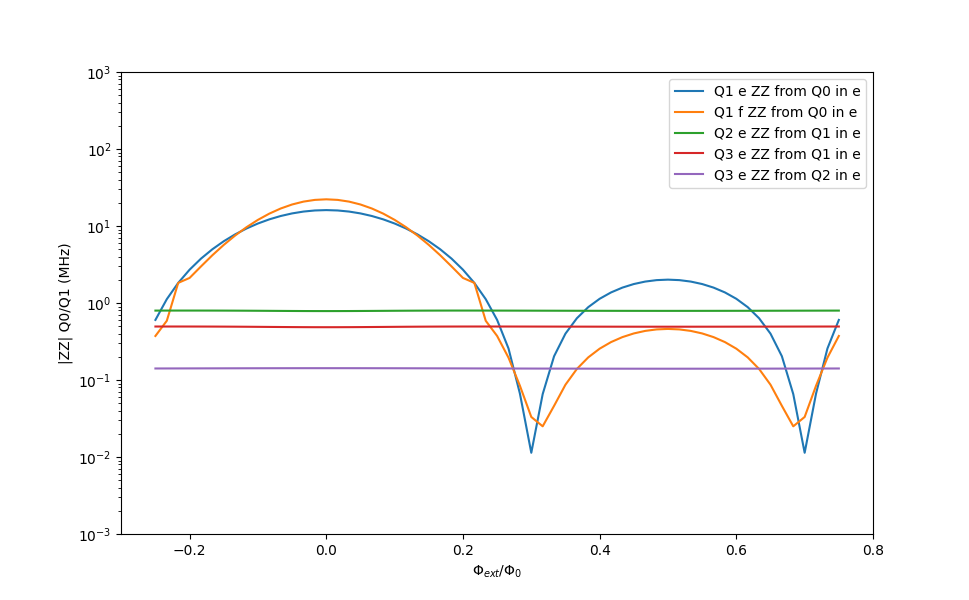

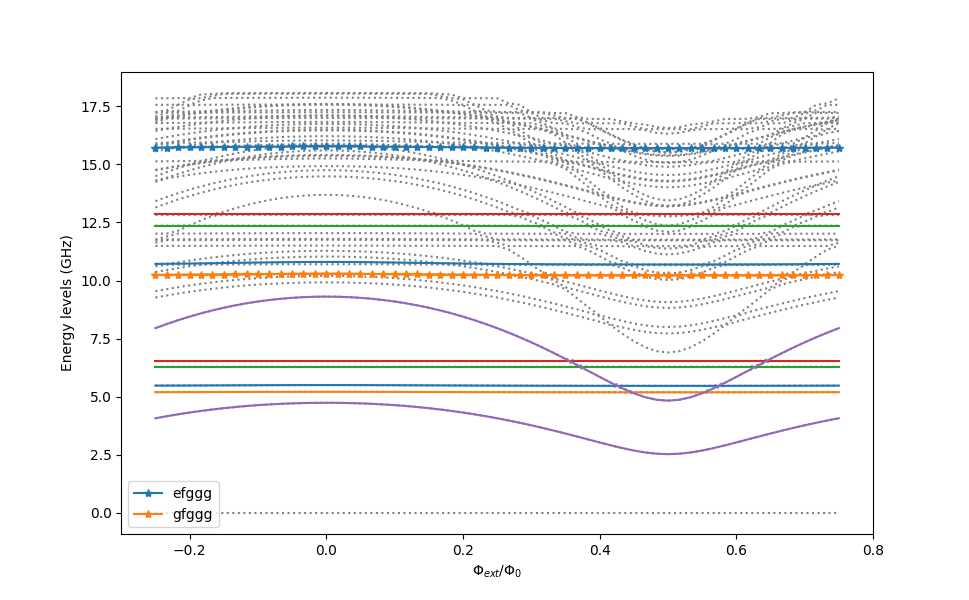

5.480779391112614
5.198945404455381
4.076349872621332


In [349]:
print('Q0/Q1 e states ZZ (MHz)')
i_flux_min_ZZ = np.argmin(np.abs(ZZ_01_flux))
print('\tMin ZZ', 1e3*ZZ_01_flux[i_flux_min_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_min_ZZ])
i_flux_max_ZZ = np.argmax(np.abs(ZZ_01_flux))
print('\tMax ZZ', 1e3*ZZ_01_flux[i_flux_max_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_max_ZZ])

print('Q0 e/Q1 f ZZ (MHz)')
i_flux_min_ZZ = np.argmin(np.abs(ZZ_01_fe_flux))
print('\tMin ZZ', 1e3*ZZ_01_fe_flux[i_flux_min_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_min_ZZ])
i_flux_max_ZZ = np.argmax(np.abs(ZZ_01_fe_flux))
print('\tMax ZZ', 1e3*ZZ_01_fe_flux[i_flux_max_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_max_ZZ])

print('Q2/Q1 e states ZZ (MHz)')
i_flux_min_ZZ = np.argmin(np.abs(ZZ_21_flux))
print('\tMin ZZ', 1e3*ZZ_21_flux[i_flux_min_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_min_ZZ])
i_flux_max_ZZ = np.argmax(np.abs(ZZ_21_flux))
print('\tMax ZZ', 1e3*ZZ_21_flux[i_flux_max_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_max_ZZ])

print('Q3/Q1 e states ZZ (MHz)')
i_flux_min_ZZ = np.argmin(np.abs(ZZ_31_flux))
print('\tMin ZZ', 1e3*ZZ_31_flux[i_flux_min_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_min_ZZ])
i_flux_max_ZZ = np.argmax(np.abs(ZZ_21_flux))
print('\tMax ZZ', 1e3*ZZ_31_flux[i_flux_max_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_max_ZZ])

print('Q2/Q3 e states ZZ (MHz)')
i_flux_min_ZZ = np.argmin(np.abs(ZZ_23_flux))
print('\tMin ZZ', 1e3*ZZ_23_flux[i_flux_min_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_min_ZZ])
i_flux_max_ZZ = np.argmax(np.abs(ZZ_23_flux))
print('\tMax ZZ', 1e3*ZZ_23_flux[i_flux_max_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_max_ZZ])

plt.figure()
plt.plot(phi_exts, abs(ZZ_01_flux)*1e3, label='Q1 e ZZ from Q0 in e')
plt.plot(phi_exts, ZZ_01_fe_flux*1e3, label='Q1 f ZZ from Q0 in e')
plt.plot(phi_exts, ZZ_21_flux*1e3, label='Q2 e ZZ from Q1 in e')
plt.plot(phi_exts, ZZ_31_flux*1e3, label='Q3 e ZZ from Q1 in e')
plt.plot(phi_exts, ZZ_23_flux*1e3, label='Q3 e ZZ from Q2 in e')
plt.axhline(0, linestyle='--', color='0.2')
plt.legend()
plt.ylim(1e-3, 1e3)
plt.yscale('log')
plt.xlabel('$\Phi_{ext}/\Phi_0$')
plt.ylabel('|ZZ| Q0/Q1 (MHz)')
plt.show()


plt.figure()
nlevels = 50
for level in range(nlevels):
    plt.plot(phi_exts, evals_flux[:, level]/2/np.pi, linestyle='dotted', color='0.5')
for q in range(len(qubit_freqs)):
    for level in range(qubit_freqs_v_flux.shape[1]):
            plt.plot(phi_exts, qubit_freqs_v_flux[q, level, :]/2/np.pi, default_colors[q])
for plot_level_name, wds in zip(plot_levels, plot_levels_wds):
    plt.plot(phi_exts, wds/2/np.pi, '*-', label=plot_level_name)
plt.legend()
plt.xlabel('$\Phi_{ext}/\Phi_0$')
plt.ylabel('Energy levels (GHz)')
plt.show()


print(qubit_freqs_v_flux[0, 0, 0]/2/np.pi)
print(qubit_freqs_v_flux[1, 0, 0]/2/np.pi)
print(qubit_freqs_v_flux[4, 0, 0]/2/np.pi)

# plt.figure()
# # plt.plot(phi_exts, wc_flux/2/np.pi, label='$f_{coupler}$')
# # plt.plot(phi_exts, dwcdflux/2/np.pi, label='$df_{coupler}/d\Phi$')
# plt.plot(phi_exts, 1e3*Omega_eff_flux, label='iSWAP $\Omega_{eff}$')
# # plt.plot(phi_exts, 1/(Del_0minus_flux * Del_1minus_flux))
# plt.axhline(0, linestyle='--', color='0.2')
# plt.xlabel('$\Phi_{ext}/\Phi_0$')
# plt.ylabel('iSWAP rate (MHz)')
# plt.legend()
# plt.show()